# Telsa Stock Price Prediction

Problem Statement: Since early 2013 the stock price of Tesla has grown six-fold. During this time, however, it has become increasingly volatile. These huge swings up and down seem irradic and obsure the overall trend of the stock. It is therefore difficult to know when to buy and sell. Tesla is a particularly odd entity as it is not profitable and so trading is much more speculative.

More immediately, I was fortunate enough to buy 3 stocks of Tesla on January 3rd, 2017.  I would like to have some idea of if and when to sell them!

Objective: Build a predictive model that estimates substantial swings in stock price and can be used to recommend buying or selling stock.  A single transaction costs $5, so any change in stance must be worth more than that.

Methods: First, use existing time series modeling techniques to try to capture any seasonality in the movements of the stock and account for momentum as rising or lowering stocks naturally encourage other traders to take action. Then attempt to account for residual affects by utilizing natural language processing on key sources. Seasonality movements in themselves could potentially be used to trade if the residual is small enough (unlikely).

NLP Key Sources:
    1. Twitter - Telsa, Elon Musk (the CEO is a notoriously heavy user), and general conversation
    2. Technology News - Sources and headlines from aggrigate news sites
    3. Public trends - Google searches, etc.

Risks: Stock prices are notoriously unpredictable.  This is also a much sought after field which is why I want to be involved.  Tesla stock is also presumed to be very connected to the overall stock market.  While it is not a part of the S&P 500, it still is represented in virtually all large holdings.  Tesla stock is therefore likely to be greatly effected by affects beyond itself.  To mitigate that somewhat, we will also want to attempt to model the seasonality and momentum of the market at large.  This will have to be incredibly simplistic give the scope of this project (and of the market!).  We will be unable to account for the relationship between the economy as a whole and Tesla itself.  Any unexpected swing of the market as a whole will not be predicted by the model.

# Tesla stock price over time

In [1]:
import pandas as pd

In [2]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)

In [3]:
stock.head()

,date,close,volume,open,high,low
1,2017/11/22,312.60,4913283.0000,316.77,317.42,311.84
2,2017/11/21,317.81,7256381.0000,310.86,318.23,308.71
3,2017/11/20,308.74,8241821.0000,313.79,315.50,304.75
4,2017/11/17,315.05,13720830.0000,325.67,326.67,313.15
5,2017/11/16,312.50,5794409.0000,313.99,318.14,311.30


In [4]:
stock.tail()

,date,close,volume,open,high,low
1862,2010/07/06,16.11,6858092.0000,20.00,20.0000,15.83
1863,2010/07/02,19.20,5135795.0000,23.00,23.1000,18.71
1864,2010/07/01,21.96,8216789.0000,25.00,25.9200,20.27
1865,2010/06/30,23.83,17165210.0000,25.79,30.4192,23.30
1866,2010/06/29,23.89,18751150.0000,19.00,25.0000,17.54


There is already a lot of information here.  The overall idea here is to have a model that could run in the morning, account for all the information from the day before and estimate the change in price of the day.  If that is larger than the transaction cost ($5 with perhaps some wiggle room), then we make a move based on the current position (whether we already have to do not have the stock).  

Target: We want to know what the difference is in the the closing price minus the openning price.  

Features: We presumably know the openning price and all of the information about how the trading of the day before went.  Volume of trading, difference between the high and low prices, difference between current openning price and closing price of day before, and others.  All of these could also have time series compenents as well...

In [5]:
stock.dtypes

date       object
close     float64
volume     object
open      float64
high      float64
low       float64
dtype: object

In [3]:
# Fix up the date column
stock.date = pd.to_datetime(stock.date)
stock = stock.sort_values('date')
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)

In [7]:
stock.head()

,close,volume,open,high,low
date,,,,,
2010-06-29,23.89,18751150.0000,19.00,25.0000,17.54
2010-06-30,23.83,17165210.0000,25.79,30.4192,23.30
2010-07-01,21.96,8216789.0000,25.00,25.9200,20.27
2010-07-02,19.20,5135795.0000,23.00,23.1000,18.71
2010-07-06,16.11,6858092.0000,20.00,20.0000,15.83


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
import matplotlib.ticker as mtick

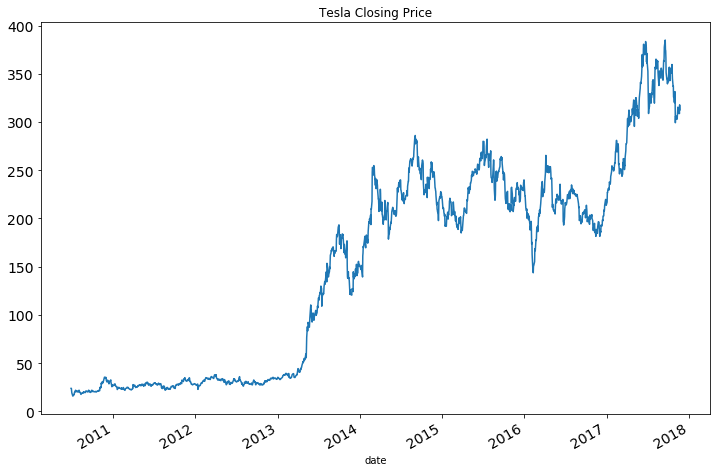

In [43]:
stock.close.plot(figsize=(12,8), title= 'Tesla Closing Price', fontsize=14)
plt.show()

Well, that's what we're dealing with!

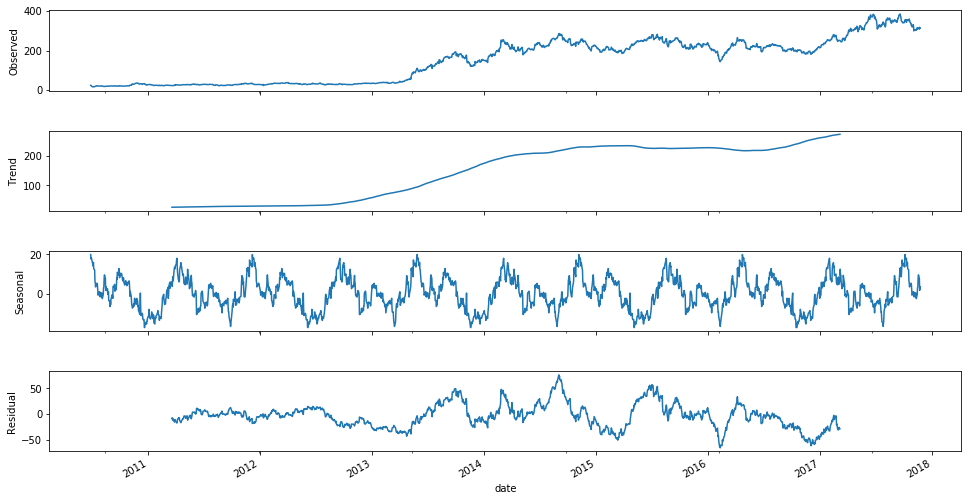

In [47]:
decomposition = seasonal_decompose(stock.close, freq=366)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.savefig('foo.png', bbox_inches='tight')
plt.show()

In [29]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    # Super not sure how to determin this... We'll have to do some research
    # 7 to 14 days seems reasonable to find overall trends
    rolmean = pd.rolling_mean(timeseries, window=14)
    rolstd = pd.rolling_std(timeseries, window=14)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  


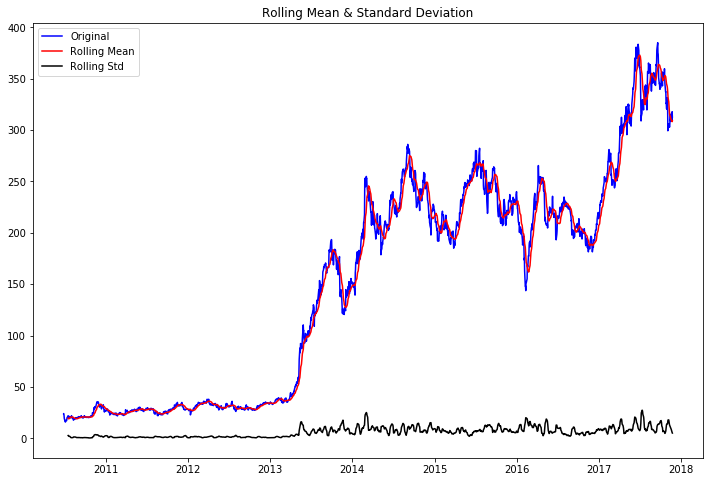

Results of Dickey-Fuller Test:
Test Statistic                   -0.785461
p-value                           0.823355
#Lags Used                        1.000000
Number of Observations Used    1864.000000
Critical Value (1%)              -3.433863
Critical Value (5%)              -2.863092
Critical Value (10%)             -2.567596
dtype: float64


In [30]:
test_stationarity(stock.close)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  


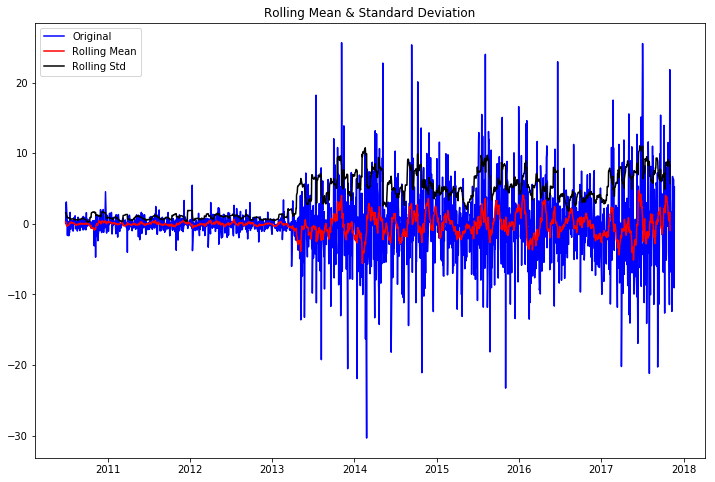

Results of Dickey-Fuller Test:
Test Statistic                  -25.528921
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1862.000000
Critical Value (1%)              -3.433867
Critical Value (5%)              -2.863093
Critical Value (10%)             -2.567597
dtype: float64


In [14]:
stock['first_difference'] = stock.close - stock.close.shift(1)  
test_stationarity(stock.first_difference.dropna(inplace=False))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  


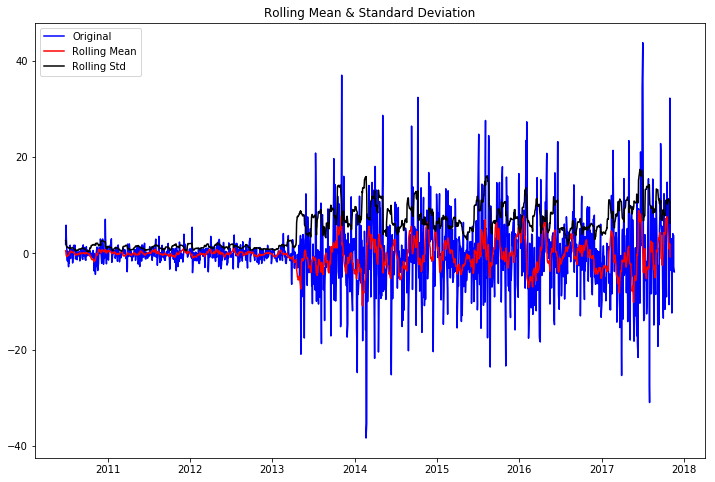

Results of Dickey-Fuller Test:
Test Statistic                -9.280826e+00
p-value                        1.252520e-15
#Lags Used                     2.500000e+01
Number of Observations Used    1.838000e+03
Critical Value (1%)           -3.433913e+00
Critical Value (5%)           -2.863114e+00
Critical Value (10%)          -2.567608e+00
dtype: float64


In [15]:
stock['second_difference'] = stock.close - stock.close.shift(2)  
test_stationarity(stock.second_difference.dropna(inplace=False))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  


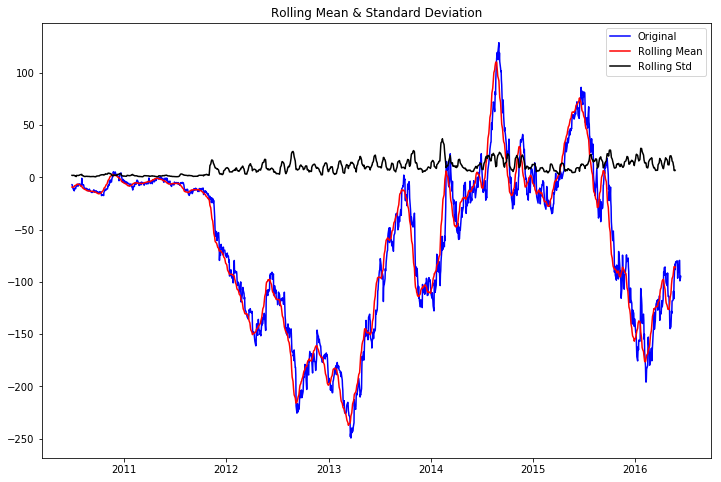

Results of Dickey-Fuller Test:
Test Statistic                   -1.820019
p-value                           0.370569
#Lags Used                        1.000000
Number of Observations Used    1498.000000
Critical Value (1%)              -3.434723
Critical Value (5%)              -2.863471
Critical Value (10%)             -2.567798
dtype: float64


In [16]:
stock['seasonal_difference'] = stock.close - stock.close.shift(366)
test_stationarity(stock.seasonal_difference.dropna(inplace=False))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  


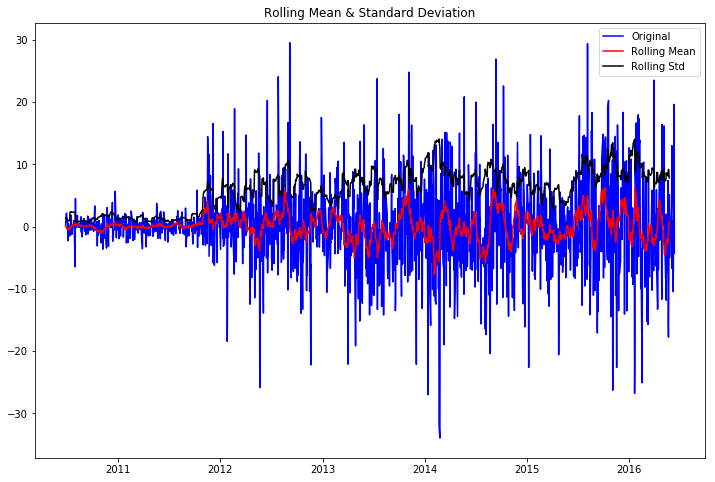

Results of Dickey-Fuller Test:
Test Statistic                  -36.117079
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1498.000000
Critical Value (1%)              -3.434723
Critical Value (5%)              -2.863471
Critical Value (10%)             -2.567798
dtype: float64


In [17]:
stock['seasonal_first_difference'] = stock.first_difference - stock.first_difference.shift(366)  
test_stationarity(stock.seasonal_first_difference.dropna(inplace=False))

In [18]:
import statsmodels.api as sm 
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

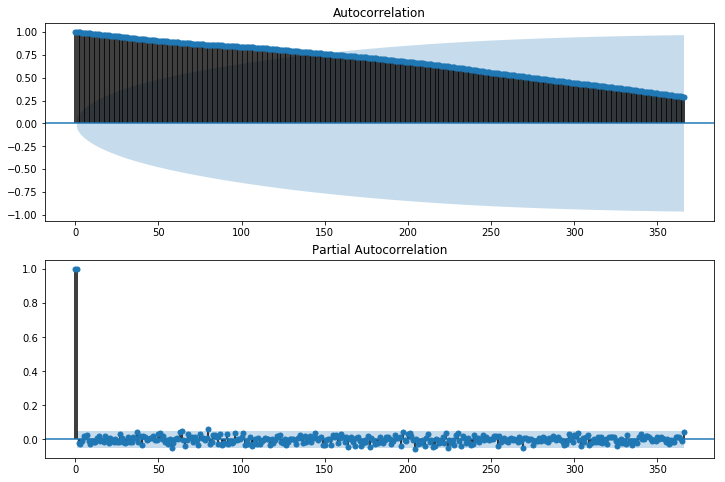

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock.close.iloc[366:], lags=366, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock.close.iloc[366:], lags=366, ax=ax2)
plt.show()

366 days for sure shows up, but also 80?

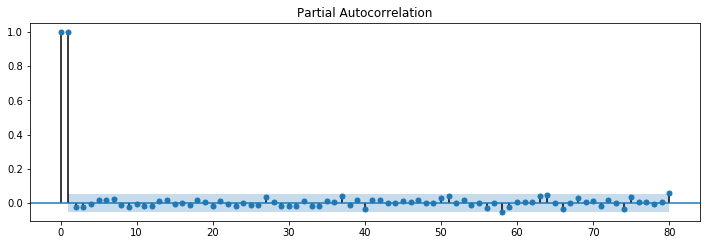

In [20]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock.close.iloc[366:], lags=80, ax=ax2)
plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


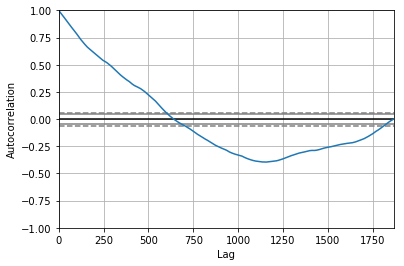

In [23]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(stock.close)
plt.show()

Not going to lie, I'm not sure what that drop means between 1000 and 1250...  Could mean there is not really any seasonality.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  


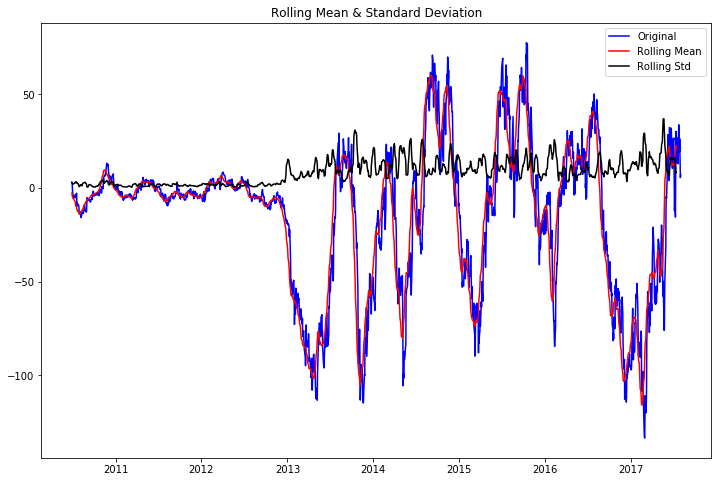

Results of Dickey-Fuller Test:
Test Statistic                   -3.730298
p-value                           0.003707
#Lags Used                        1.000000
Number of Observations Used    1784.000000
Critical Value (1%)              -3.434021
Critical Value (5%)              -2.863161
Critical Value (10%)             -2.567633
dtype: float64


In [104]:
stock['other_seasonal_difference'] = stock.close - stock.close.shift(80)
test_stationarity(stock.other_seasonal_difference.dropna(inplace=False))

But ploting 80 definitely looks like there is seasonality here!

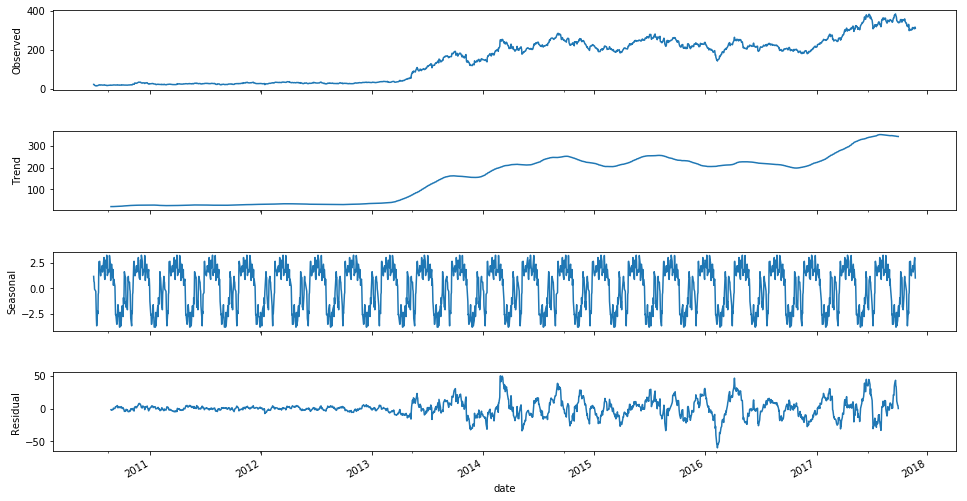

In [105]:
decomposition = seasonal_decompose(stock.close, freq=80)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

The 80 day seasonal effect does not appear to be as powerful as 366 day one, but it is more sound. I can look at predictions from both and see which performs better. I wonder if it is possible to incorporate both?

# Presentation plots

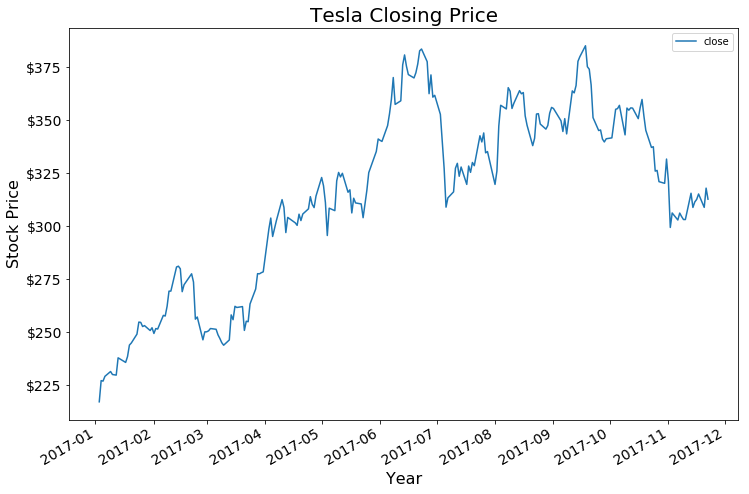

In [46]:
fig, ax = plt.subplots()
ax=stock[['close']].iloc[1640:].plot(figsize=(12,8), title= 'Tesla Closing Price', fontsize=14, ax=ax)
plt.title('Tesla Closing Price', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.yticks()
plt.savefig('foo.png', bbox_inches='tight')
plt.show()

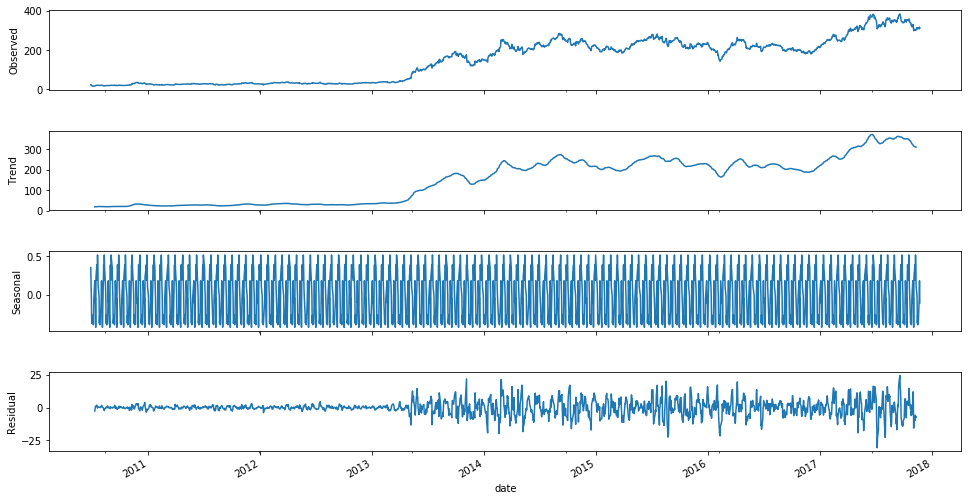

In [48]:
decomposition = seasonal_decompose(stock.close, freq=16)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

In [50]:
def rolmean_plot(timeseries):
    
    #Determing rolling statistics
    # Super not sure how to determin this... We'll have to do some research
    # 7 to 14 days seems reasonable to find overall trends
    rolmean3 = pd.rolling_mean(timeseries, window=3)
    rolmean7 = pd.rolling_mean(timeseries, window=7)
    rolmean14 = pd.rolling_mean(timeseries, window=14)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[1740:], color='blue',label='Original')
    mean3 = plt.plot(rolmean3.iloc[1740:], color='red', label='Rolling Mean 3 Days')
    mean7 = plt.plot(rolmean7.iloc[1740:], color='green', label='Rolling Mean 7 Days')
    mean14 = plt.plot(rolmean14.iloc[1740:], color='orange', label='Rolling Mean 14 Days')
    plt.legend(loc='best')
    plt.title('Rolling Mean Comparisons',fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.savefig('rolmean.png', bbox_inches='tight')
    plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  


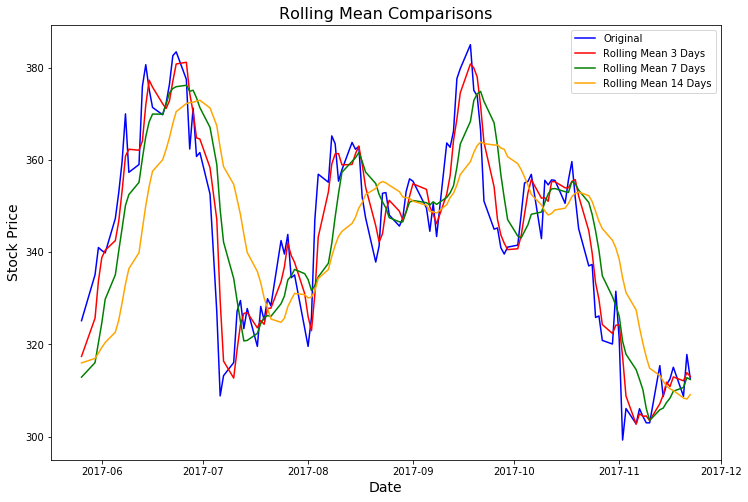

In [51]:
rolmean_plot(stock.close)